In [38]:


#Usado em todo Projeto 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



In [39]:
teste = pd.read_csv("Corona_NLP_test.csv")
treino = pd.read_csv("Corona_NLP_train.csv",encoding='latin-1')

data = pd.concat([teste,treino])
data = data.sample(frac=0.5, random_state=42)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22478 entries, 29256 to 10047
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       22478 non-null  int64 
 1   ScreenName     22478 non-null  int64 
 2   Location       17816 non-null  object
 3   TweetAt        22478 non-null  object
 4   OriginalTweet  22478 non-null  object
 5   Sentiment      22478 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.2+ MB


## Tratar dados

In [40]:
# Remover as colubas que não nós influencia

data = data.drop(columns=[ "UserName","ScreenName","Location","TweetAt"], axis=1)

In [41]:
def categorize_sentiment(score):
    if score == 'Negative':
        return "Negative"
    elif score == 'Extremely Negative':
        return "Negative"
    elif score == 'Positive':
        return "Positive"
    elif score == 'Extremely Positive':
        return "Positive"
    else:
        return "Neutral"

In [42]:
data['Sentiment'] = data['Sentiment'].apply(categorize_sentiment)

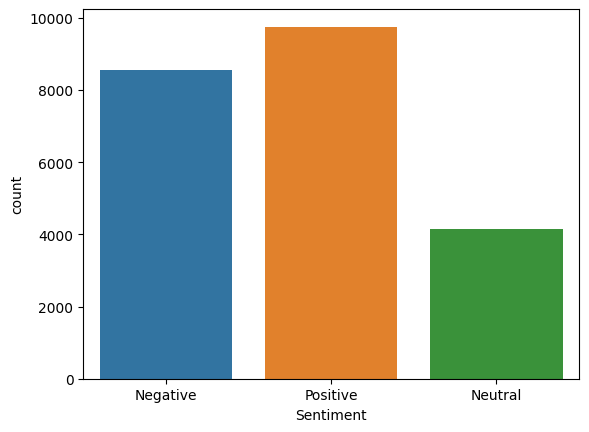

In [43]:
sns.countplot(x=data["Sentiment"])
plt.show()

In [44]:
# Fazer TOKENIZACAO das palavras

import nltk

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alexa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alexa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [45]:
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


import string

wnl = WordNetLemmatizer()
stop_words = stopwords.words('english')

def clean_text(text):
    text = text.lower().split()

    # Remover a pontuação das palavras
    text = [word.translate(str.maketrans('', '', string.punctuation)) for word in text]
    
    #Remover as stopwords do textos
    text = [word for word in text if word not in stop_words]

    #Lemmarization das palavras
    text = [wnl.lemmatize(word) for word in text]
    joined = ' '.join(text)

    return joined



In [46]:
data['text'] = data["OriginalTweet"].apply(clean_text)

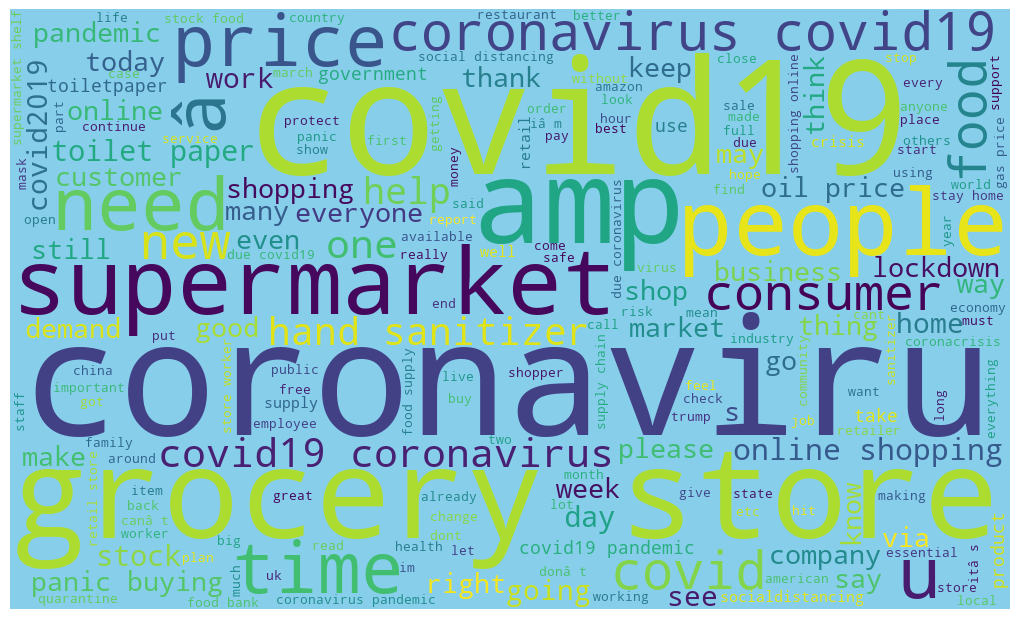

In [47]:
all_words = ' '.join(word for word in data['text'])
from wordcloud import WordCloud
wordcloud = WordCloud(
    width = 1000,
    height = 600,
    background_color = 'skyblue',
    min_font_size = 10).generate(all_words)
plt.figure(figsize = (10, 6), facecolor = None) 
plt.imshow(wordcloud)
plt.axis('off') 
plt.tight_layout(pad = 0) 
plt.show()



In [48]:
all_words = all_words.split()


In [49]:
from nltk.probability import FreqDist
fq =  FreqDist(word for word in all_words)

In [50]:
fq.most_common(10)

[('coronavirus', 9711),
 ('covid19', 9594),
 ('price', 4764),
 ('store', 4685),
 ('food', 4336),
 ('supermarket', 4159),
 ('grocery', 3800),
 ('people', 3091),
 ('amp', 2705),
 ('consumer', 2606)]

In [51]:
y = data["Sentiment"]


In [52]:
data = data.drop(columns=["Sentiment"])

In [53]:
def get_all_str(tweet):
    sentence = ''
    for words in tweet:
        sentence += words
    sentence = sentence.lower()
    return sentence
def get_str(lst):
    sentence = ''
    for char in lst:
        sentence += char+' '
    sentence = sentence.lower()
    return sentence

def get_word(text): 
    result = nltk.RegexpTokenizer(r'\w+').tokenize(text.lower())
    return result

def get_hashtag(text):
    result = nltk.RegexpTokenizer(r'(?<=#)\w+').tokenize(text.lower())
    return result

def get_mention(text):
    result = nltk.RegexpTokenizer(r'(?<=@)\w+').tokenize(text.lower())
    return result 

def stopword_list(stop):
    lst = stopwords.words('english')
    for stopword in stop:
        lst.append(stopword)
    return lst

def remove_stopword(stopwords, lst):    
    stoplist = stopword_list(stopwords)
    txt = ''
    for idx in range(len(lst)):
        txt += lst[idx]
        txt += '\n'
    cleanwordlist = [word for word in txt.split() if word not in stoplist] 
#     print(stoplist)
    return cleanwordlist

def pos_remove_noun(tagged):
    remove_noun = [word for word,pos in tagged if pos not in ['NN','NNS','NNP','NNPS']]
    txt = ''
    for i in range(len(remove_noun)):
        txt += remove_noun[i]
        txt += '\n'
    return cleanwordlist

def lemmatization(words):
    lemm = WordNetLemmatizer()
    tokens = [lemm.lemmatize(word) for word in words]
#     txt= ' '.join(tokens)
    return tokens

def Freq_df(cleanwordlist):
    Freq_dist_nltk = nltk.FreqDist(cleanwordlist)
    df_freq = pd.DataFrame.from_dict(Freq_dist_nltk, orient='index')
    df_freq.columns = ['Frequency']
    df_freq.index.name = 'Term'
    df_freq = df_freq.sort_values(by=['Frequency'],ascending=False)
    df_freq = df_freq.reset_index()
    return df_freq

In [58]:
def preprocessing(text):
    words = get_word(text)
    lemma = lemmatization(words)
    removed = remove_stopword(['http','ly'],lemma)
    return removed

data['OriginalTweet'] = data['OriginalTweet'].apply(preprocessing)
data['OriginalTweet'] = data['OriginalTweet'].apply(get_str)

In [62]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
le = LabelEncoder()
y =  le.fit_transform(y)

vector = CountVectorizer()

X = vector.fit(data['OriginalTweet'])
X_transform = X.transform(data['OriginalTweet'])

In [63]:
Tfidf = TfidfTransformer()
tfidf_transformer = Tfidf.fit(X_transform)
X = tfidf_transformer.transform(X_transform)

In [64]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5,random_state=42)

In [65]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
XTrain = pca.fit_transform(X_train)
XTest = pca.transform(X_test)

TypeError: PCA does not support sparse input. See TruncatedSVD for a possible alternative.

In [ ]:
# print(pca.explained_variance_ratio_)

In [ ]:
from sklearn.linear_model import LogisticRegression


model = LogisticRegression(max_iter=10000, random_state=42)
model.fit(X_train, y_train)


LogisticRegression(max_iter=10000, random_state=42)

In [ ]:
from sklearn.linear_model import SGDClassifier
modelSGDL = SGDClassifier(loss='log_loss', random_state=42)
modelSGDL.fit(X_train, y_train)

SGDClassifier(loss='log_loss', random_state=42)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

modelTree = DecisionTreeClassifier(random_state=42)
modelTree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [ ]:
y_pred = model.predict(X_test)
y_pred_SGDL = modelSGDL.predict(X_test)
y_pred_Tree = modelTree.predict(X_test)

In [ ]:
#Creating a function to display model results
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

def evaluation_parametrics(name,y_test, y_pred):
    cm_test = confusion_matrix(y_test, y_pred )
    t1 = ConfusionMatrixDisplay(cm_test, display_labels=["Negative","Positive","Neutral"])    
    print("Classification Report for Data Test")
    print(classification_report(y_test, y_pred))
    t1.plot()

Classification Report for Data Test
              precision    recall  f1-score   support

           0       0.72      0.75      0.74      4283
           1       0.63      0.46      0.53      2036
           2       0.74      0.80      0.77      4920

    accuracy                           0.72     11239
   macro avg       0.70      0.67      0.68     11239
weighted avg       0.72      0.72      0.71     11239



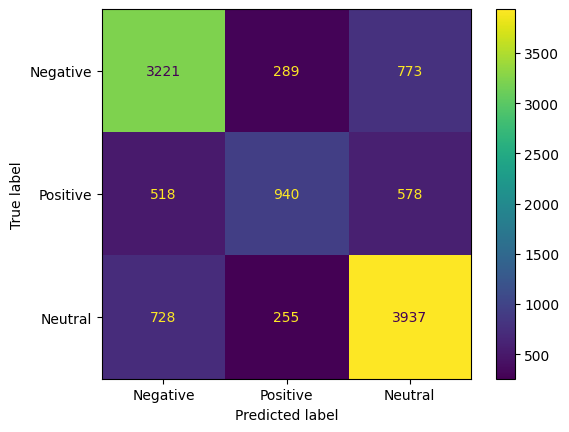

In [ ]:
#Visualizing model results
evaluation_parametrics("Machine Learning - Classification", y_test, y_pred)

Classification Report for Data Test
              precision    recall  f1-score   support

           0       0.72      0.74      0.73      4283
           1       0.65      0.41      0.50      2036
           2       0.72      0.81      0.76      4920

    accuracy                           0.71     11239
   macro avg       0.70      0.65      0.66     11239
weighted avg       0.71      0.71      0.70     11239



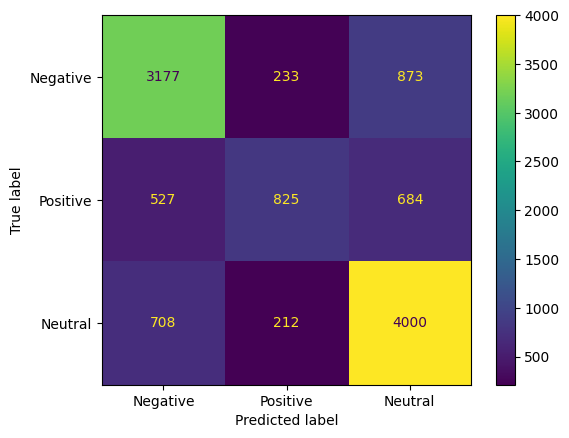

In [ ]:
#Visualizing model results
evaluation_parametrics("Machine Learning - Classification", y_test, y_pred_SGDL)

Classification Report for Data Test
              precision    recall  f1-score   support

           0       0.61      0.55      0.58      4283
           1       0.42      0.51      0.46      2036
           2       0.65      0.64      0.65      4920

    accuracy                           0.58     11239
   macro avg       0.56      0.57      0.56     11239
weighted avg       0.59      0.58      0.59     11239



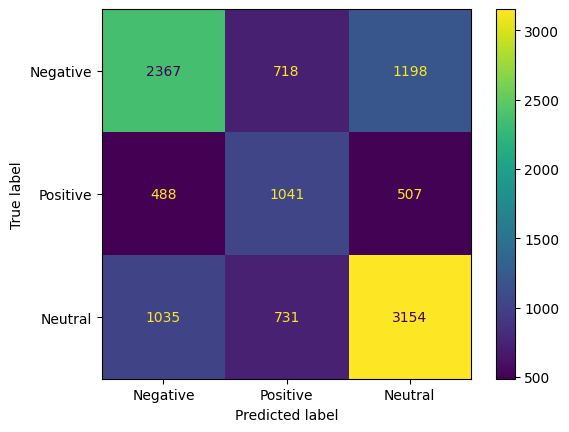

In [ ]:
#Visualizing model results
evaluation_parametrics("Machine Learning - Classification", y_test, y_pred_Tree)